imports

In [40]:
!pip install scikit-learn

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
import numpy as np
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.callbacks import EarlyStopping


loading the dataset

In [46]:
data = pd.read_csv('raw_sales.csv')
data['datesold'] = pd.to_datetime(data['datesold'])
data.set_index('datesold', inplace=True)


Data exploration

In [47]:
print(data.head())
print(data.info())
print(data.describe())

            postcode   price propertyType  bedrooms
datesold                                           
2007-02-07      2607  525000        house         4
2007-02-27      2906  290000        house         3
2007-03-07      2905  328000        house         3
2007-03-09      2905  380000        house         4
2007-03-21      2906  310000        house         3
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29580 entries, 2007-02-07 to 2019-07-26
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   postcode      29580 non-null  int64 
 1   price         29580 non-null  int64 
 2   propertyType  29580 non-null  object
 3   bedrooms      29580 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.1+ MB
None
           postcode         price      bedrooms
count  29580.000000  2.958000e+04  29580.000000
mean    2730.249730  6.097363e+05      3.250169
std      146.717292  2.817079e+05      0.951275
min     2600

data scaling

In [49]:
scaler = MinMaxScaler()
scaler.fit(data[['price']])
data['price_scaled'] = scaler.transform(data[['price']])


feature engineering

In [50]:
data['price_lagged'] = data['price_scaled'].shift(1)
data.dropna(inplace=True)

data preprocessing

In [51]:
data.isnull().sum()

,0
postcode,0
price,0
propertyType,0
bedrooms,0
price_scaled,0
price_lagged,0


spliting the data

In [52]:
train_size = int(len(data) * 0.8)
train_data = data[:train_size]
test_data = data[train_size:]

arma modelling

In [53]:
p = 2
q = 2
model_arma = ARIMA(train_data['price_scaled'], order=(p, 0, q))
model_fit_arma = model_arma.fit()
predictions_arma = model_fit_arma.predict(start=len(train_data), end=len(data) - 1)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/u

LSTM modeling

In [54]:
def prepare_data_for_rnn(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        seq_x = data[i:i + n_steps]
        seq_y = data[i + n_steps]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

n_steps = 10
X_train, y_train = prepare_data_for_rnn(train_data['price_scaled'], n_steps)
X_test, y_test = prepare_data_for_rnn(test_data['price_scaled'], n_steps)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


<ipython-input-54-5765fe1403e7>:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  seq_y = data[i + n_steps]


In [55]:
def create_lstm_model(units=50):
    model = Sequential()
    model.add(LSTM(units, activation='relu', input_shape=(n_steps, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

In [56]:
param_grid = {'units': [30, 50, 70]}
best_score = float('inf')
best_model = None


In [57]:
for units in param_grid['units']:
    model = create_lstm_model(units=units)
    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)
    history = model.fit(X_train, y_train, epochs=100, batch_size=32,
                        validation_split=0.2, callbacks=[early_stopping], verbose=0)
    val_loss = history.history['val_loss'][-1]

    if val_loss < best_score:
        best_score = val_loss
        best_model = model

predictions_lstm = best_model.predict(X_test)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


GRU modeling

In [58]:
model_gru = Sequential()
model_gru.add(GRU(50, activation='relu', input_shape=(n_steps, 1)))
model_gru.add(Dense(1))
model_gru.compile(optimizer='adam', loss='mse')
model_gru.fit(X_train, y_train, epochs=50, verbose=1)
predictions_gru = model_gru.predict(X_test)


Epoch 1/50
740/740 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0014
Epoch 2/50
740/740 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 9.3102e-04
Epoch 3/50
740/740 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 8.9497e-04
Epoch 4/50
740/740 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 8.5943e-04
Epoch 5/50
740/740 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0010
Epoch 6/50
740/740 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - loss: 9.2302e-04
Epoch 7/50
740/740 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0010
Epoch 8/50
740/740 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 9.2706e-04
Epoch 9/50
740/740 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.0010
Epoch 10/50
740/740 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 9.1237e-04
Epoch 11/50
740/740 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 9.7733e-04
Epoch 12/50
740/740 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 8.5456e-04
Epoch 13/50
740/740 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 8.9980e-04
Epoch 14/50
740/740 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 8.6966e-04
Epoch 15/50


evaluation

In [60]:
rmse_arma = mean_squared_error(test_data['price_scaled'][n_steps:], predictions_arma[n_steps:])**0.5  # Calculate RMSE manually
rmse_lstm = mean_squared_error(y_test, predictions_lstm)**0.5  # Calculate RMSE manually
rmse_gru = mean_squared_error(y_test, predictions_gru)**0.5  # Calculate RMSE manually

print('ARMA RMSE:', rmse_arma)
print('LSTM RMSE:', rmse_lstm)
print('GRU RMSE:', rmse_gru)

ARMA RMSE: 0.034722653784478454
LSTM RMSE: 0.023511507378708843
GRU RMSE: 0.024254103567893016


In [61]:
if rmse_lstm < rmse_arma and rmse_lstm < rmse_gru:
    print('LSTM model performed the best in terms of RMSE.')
elif rmse_arma < rmse_lstm and rmse_arma < rmse_gru:
    print('ARMA model performed the best in terms of RMSE.')
else:
    print('GRU model performed the best in terms of RMSE.')

LSTM model performed the best in terms of RMSE.


Visualizations

Time Series Plot of Actual vs. Predicted Values:

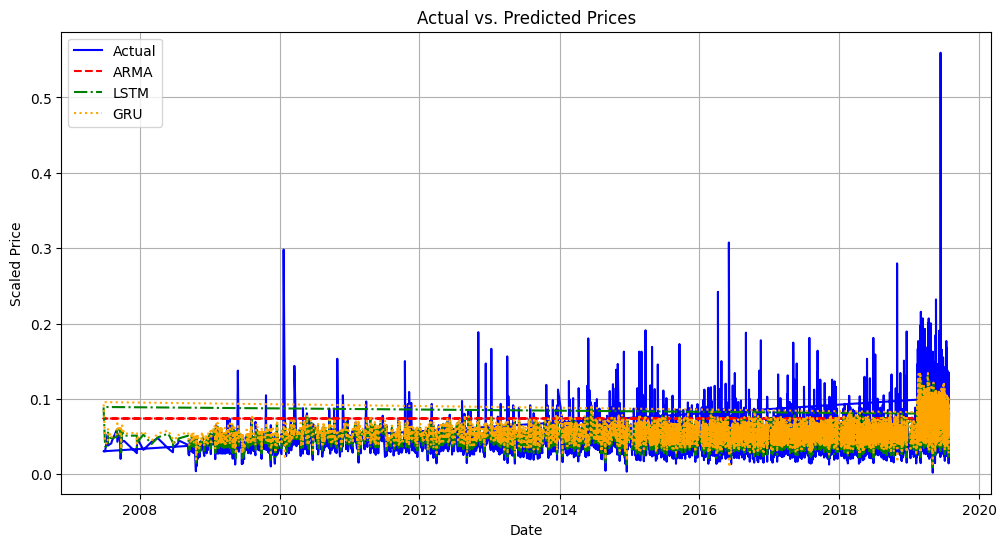

In [62]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(test_data.index[n_steps:], test_data['price_scaled'][n_steps:], label='Actual', color='blue')
plt.plot(test_data.index[n_steps:], predictions_arma[n_steps:], label='ARMA', color='red', linestyle='--')
plt.plot(test_data.index[n_steps:], predictions_lstm, label='LSTM', color='green', linestyle='-.')
plt.plot(test_data.index[n_steps:], predictions_gru, label='GRU', color='orange', linestyle=':')
plt.title('Actual vs. Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Scaled Price')
plt.legend()
plt.grid(True)
plt.show()

Residual Plots:



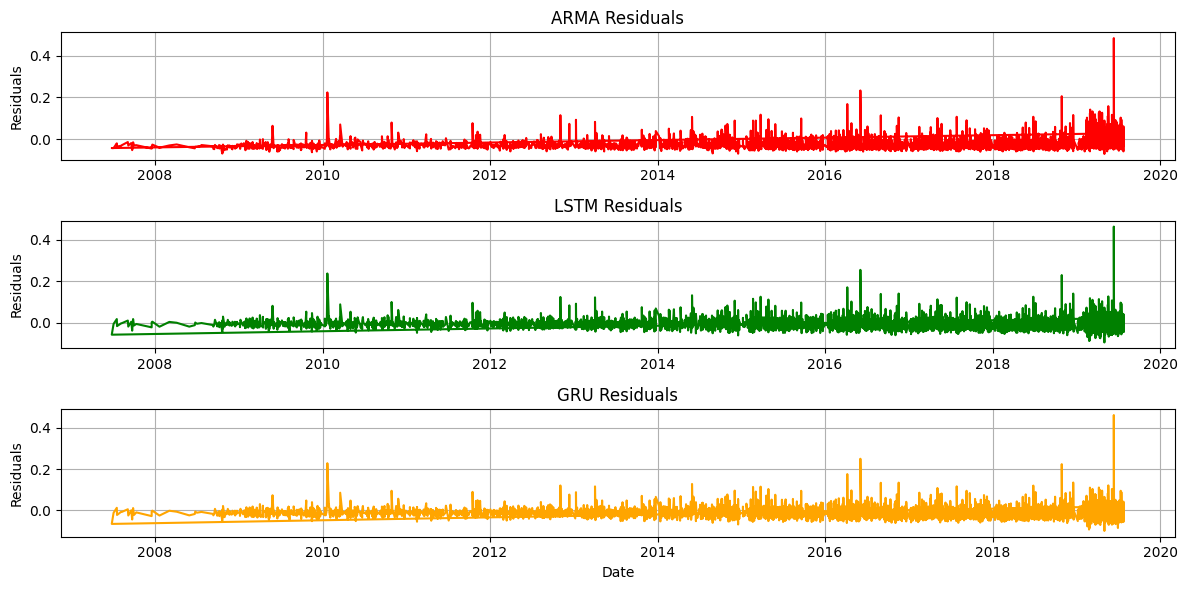

In [64]:
residuals_arma = test_data['price_scaled'][n_steps:].values - predictions_arma[n_steps:].values
# Accessing the values of the Series to perform the subtraction avoids the index alignment issue
residuals_lstm = y_test - predictions_lstm.flatten()
residuals_gru = y_test - predictions_gru.flatten()

plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(test_data.index[n_steps:], residuals_arma, color='red')
# The x-axis remains the same, representing the dates
plt.title('ARMA Residuals')
plt.ylabel('Residuals')
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(test_data.index[n_steps:], residuals_lstm, color='green')
# The x-axis remains the same
plt.title('LSTM Residuals')
plt.ylabel('Residuals')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(test_data.index[n_steps:], residuals_gru, color='orange')
# The x-axis remains the same
plt.title('GRU Residuals')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.grid(True)

plt.tight_layout()
plt.show()

Distribution of Residuals (Histograms):

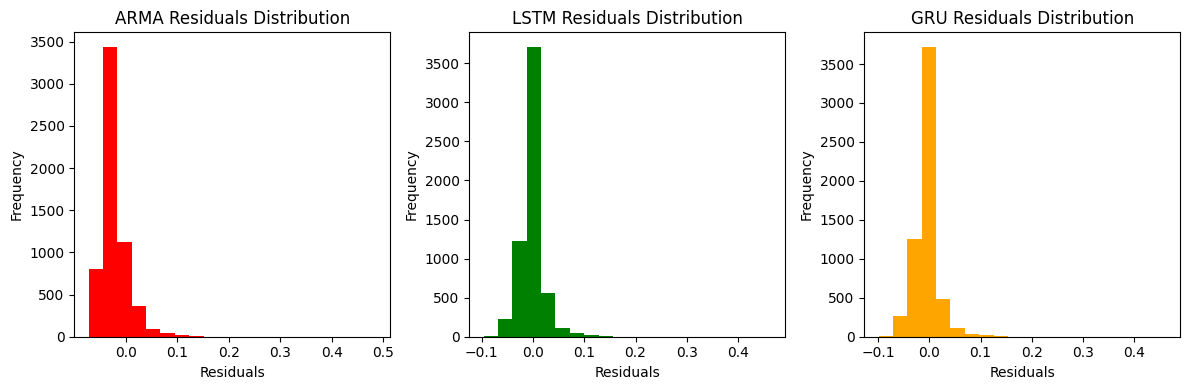

In [65]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.hist(residuals_arma, bins=20, color='red')
plt.title('ARMA Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(residuals_lstm, bins=20, color='green')
plt.title('LSTM Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.hist(residuals_gru, bins=20, color='orange')
plt.title('GRU Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

ACF and PACF Plots (for ARMA):

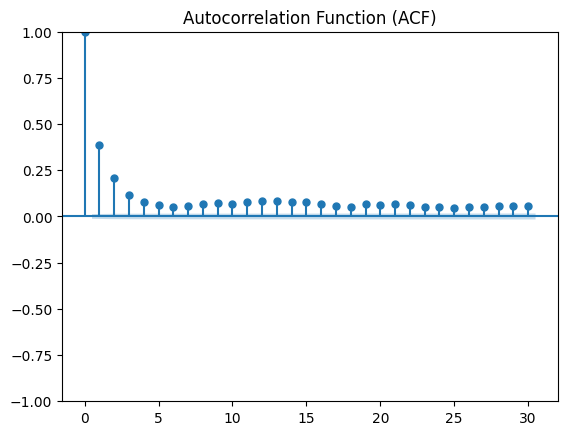

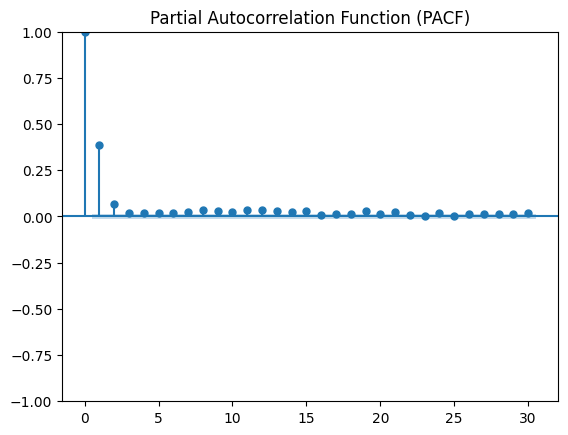

In [66]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF Plot
plot_acf(train_data['price_scaled'], lags=30)
plt.title('Autocorrelation Function (ACF)')
plt.show()

# PACF Plot
plot_pacf(train_data['price_scaled'], lags=30)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()